# Import Modules

In [156]:
import sys
import os
import pandas as pd
import tqdm as tqdm
import xgboost as xgb
import numpy as np

# Import your custom modules. Adjust the module paths as needed.
from src.data.load_data import loadTrainingData
from sklearn.model_selection import train_test_split
from src.features.create_feature_vectors import extract_features_with_expanding_window
from src.plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from sklearn.metrics import classification_report,fbeta_score,confusion_matrix
from sklearn import set_config

set_config(display="text")


# Load Data

In [157]:
directories = ['../../training_setA/', '../../training_setB/']
max_files = None  # Adjust as needed

patient_dict = {}

for directory in directories:
    pattern = os.path.join(directory, "*.psv")
    print(f"\nLoading data from: {pattern} with max_files={max_files}")
    patient_data = loadTrainingData(
        pattern,
        max_files,
        ignore_columns=['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime']
    )
    patient_dict.update(patient_data)


Loading data from: ../../training_setA/*.psv with max_files=None


Loading PSV Files: 100%|██████████| 20336/20336 [00:20<00:00, 1002.19it/s]



Loading data from: ../../training_setB/*.psv with max_files=None


Loading PSV Files: 100%|██████████| 20000/20000 [00:22<00:00, 875.95it/s] 


# Create Feature Vectors

In [ ]:
feature_df = extract_features_with_expanding_window(patient_dict)

Combined data shape: (1552210, 36)


Extracting features with expanding window: 100%|██████████| 40336/40336 [17:50<00:00, 37.69it/s]
[Parallel(n_jobs=-1)]: Done 40336 out of 40336 | elapsed: 17.9min finished


 # Save or Load Feature

In [ ]:
def save_feature_data(feature_df, file_path="feature_data.pkl"):
    feature_df.to_pickle(file_path)
    print(f"Feature data saved to {file_path}")

def load_feature_data(file_path="feature_data.pkl"):
    feature_df = pd.read_pickle(file_path)
    print(f"Feature data loaded from {file_path}")
    return feature_df

# feature_df = load_feature_data()
save_feature_data(feature_df)

# Add/Remove features

In [ ]:
feature_df.columns

Index(['HR_ns_NaN', 'HR_sw_mean_5', 'HR_sw_min_5', 'HR_sw_max_5',
       'HR_sw_median_5', 'HR_sw_var_5', 'HR_sw_q95_5', 'HR_sw_q99_5',
       'HR_sw_q05_5', 'HR_sw_q01_5',
       ...
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'ICULOS', 'SepsisLabel', 'patient_id'],
      dtype='object', length=275)

# Split Sets into Test and Train on Patient ID of Dictionary

In [ ]:
# Group rows by patient_id to create a patient-wise dictionary.
patient_groups = {patient_id: group 
                  for patient_id, group in feature_df.groupby("patient_id")}

# Create a new dictionary with keys indicating sepsis status.
# For each patient, if any row's SepsisLabel equals 1, mark that patient as sepsis.
labeled_patients = {}
for patient_id, df in patient_groups.items():
    # Check if the patient ever had sepsis
    sepsis_label = "1" if df["SepsisLabel"].any() else "0"
    new_key = f"{patient_id}_{sepsis_label}"
    labeled_patients[new_key] = df

# Optional: Print counts to verify split counts
sepsis_count = sum(1 for key in labeled_patients if key.endswith('_1'))
nonsepsis_count = sum(1 for key in labeled_patients if key.endswith('_0'))
print(f"Number of SEPSIS patients: {sepsis_count}")
print(f"Number of NON-SEPSIS patients: {nonsepsis_count}")

# Now, create a list of keys and a matching list of binary labels for stratification.
keys = list(labeled_patients.keys())
labels = [1 if key.endswith('_sepsis') else 0 for key in keys]  # 1 = sepsis, 0 = no sepsis

# Split the keys into train and test sets while maintaining the sepsis proportion.
train_keys, test_keys, _, _ = train_test_split(
    keys, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build train and test dictionaries from the split keys.
train_data_dict = {key: labeled_patients[key] for key in train_keys}
test_data_dict = {key: labeled_patients[key] for key in test_keys}

# Optional: Verify the stratification in your splits.
train_sepsis = sum(1 for key in train_data_dict if key.endswith('_1'))
test_sepsis = sum(1 for key in test_data_dict if key.endswith('_1'))
print(f"Train SEPSIS: {train_sepsis}, NON-SEPSIS: {len(train_data_dict) - train_sepsis}")
print(f"Test SEPSIS: {test_sepsis}, NON-SEPSIS: {len(test_data_dict) - test_sepsis}")

# If needed, you can also concatenate these dictionaries back into DataFrames:
train_df = pd.concat(train_data_dict.values(), ignore_index=True)
test_df = pd.concat(test_data_dict.values(), ignore_index=True)

train_df = train_df.drop(columns=['patient_id'])
test_df = test_df.drop(columns=['patient_id'])

Number of SEPSIS patients: 142
Number of NON-SEPSIS patients: 1858
Train SEPSIS: 105, NON-SEPSIS: 1495
Test SEPSIS: 37, NON-SEPSIS: 363


#  Train Model

In [ ]:
# Separate features and target
X_train = train_df.drop(columns=["SepsisLabel"], errors="ignore")
y_train = train_df["SepsisLabel"]

X_test = test_df.drop(columns=["SepsisLabel"], errors="ignore")
y_test = test_df["SepsisLabel"]

neg_samples, pos_samples = y_train.value_counts()
neg_samples_test, pos_samples_test = y_test.value_counts()
print(f"Negative samples of Train: {neg_samples}, Positive samples of Train: {pos_samples}")
print(f"Negative samples of Test: {neg_samples_test}, Positive samples of Test: {pos_samples_test}")

Negative samples of Train: 61374, Positive samples of Train: 1008
Negative samples of Test: 14681, Positive samples of Test: 352


In [ ]:
# Cell 5: Train model
model = xgb.XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    eval_metric="auc",
    scale_pos_weight=neg_samples / pos_samples
)
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=1)

[0]	validation_0-auc:0.60165
[1]	validation_0-auc:0.63529
[2]	validation_0-auc:0.67051
[3]	validation_0-auc:0.65068
[4]	validation_0-auc:0.64882
[5]	validation_0-auc:0.62977
[6]	validation_0-auc:0.63448
[7]	validation_0-auc:0.64033
[8]	validation_0-auc:0.64377
[9]	validation_0-auc:0.64482
[10]	validation_0-auc:0.65016
[11]	validation_0-auc:0.64734
[12]	validation_0-auc:0.65516
[13]	validation_0-auc:0.64840
[14]	validation_0-auc:0.64745
[15]	validation_0-auc:0.64875
[16]	validation_0-auc:0.64956
[17]	validation_0-auc:0.66097
[18]	validation_0-auc:0.65631
[19]	validation_0-auc:0.64904
[20]	validation_0-auc:0.65144
[21]	validation_0-auc:0.63797
[22]	validation_0-auc:0.64550
[23]	validation_0-auc:0.64661
[24]	validation_0-auc:0.64888
[25]	validation_0-auc:0.64890
[26]	validation_0-auc:0.64813
[27]	validation_0-auc:0.65581
[28]	validation_0-auc:0.64987
[29]	validation_0-auc:0.64701
[30]	validation_0-auc:0.64315
[31]	validation_0-auc:0.64109
[32]	validation_0-auc:0.64387
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# Evaluate Model

Subset ROC AUC (predicted=1 or actual=1): 0.020


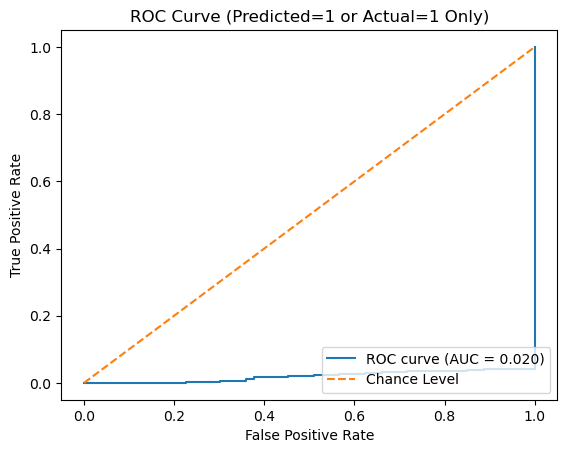

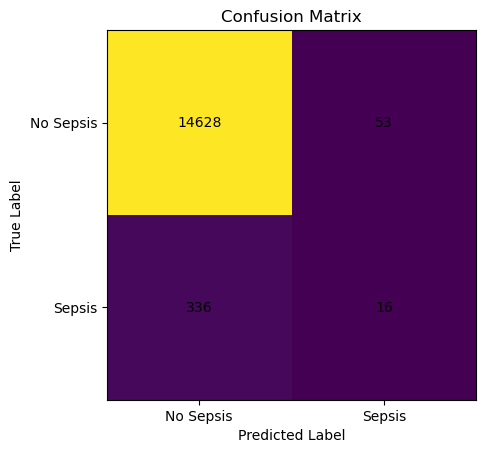


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     14681
         1.0       0.23      0.05      0.08       352

    accuracy                           0.97     15033
   macro avg       0.60      0.52      0.53     15033
weighted avg       0.96      0.97      0.97     15033



In [ ]:
from src.plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

plot_roc_auc(model, X_test, y_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=("No Sepsis", "Sepsis"))

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Maximise Threshold

In [ ]:
thresholds = np.arange(0.0, 1.0, 0.01)

f_beta_scores = []
beta_val = 5.5

for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    fb = fbeta_score(y_test, y_pred_threshold, beta=beta_val)
    f_beta_scores.append(fb)

optimal_threshold = thresholds[np.argmax(f_beta_scores)]
print(f"Optimal threshold: {optimal_threshold}, F Beta {beta_val} Score: {max(f_beta_scores)}")

Optimal threshold: 0.0, F Beta 5.5 Score: 0.4283322300533468


# Re-evaluate Model

Subset ROC AUC (predicted=1 or actual=1): 0.641


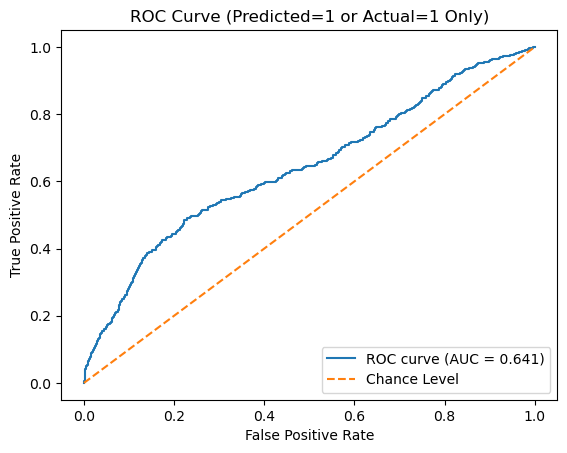

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     14681
         1.0       0.02      1.00      0.05       352

    accuracy                           0.02     15033
   macro avg       0.01      0.50      0.02     15033
weighted avg       0.00      0.02      0.00     15033

[[    0 14681]
 [    0   352]]


/Users/lukeedwards/anaconda3/envs/ADL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lukeedwards/anaconda3/envs/ADL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lukeedwards/anaconda3/envs/ADL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [ ]:
# Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the threshold to get the new predictions
y_pred_custom = (y_proba >= optimal_threshold).astype(int)


plot_roc_auc(model, X_test, y_test, optimal_threshold)

print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

# Feature Importance

In [ ]:
feature_importances = model.feature_importances_
features = X_test.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

                Feature  Importance
272              ICULOS    0.106672
227    PTT_miss_LCV_var    0.027439
171  PaCO2_miss_LCV_var    0.021173
43        Temp_sw_max_5    0.017903
129       Resp_sw_q01_5    0.017367
..                  ...         ...
239               O2Sat    0.000000
240                Temp    0.000000
241                 SBP    0.000000
242                 MAP    0.000000
0             HR_ns_NaN    0.000000

[273 rows x 2 columns]


# Shap Importance

# Utility Score

# Most Important Features